In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


# Data analysis

In [2]:
data = pd.read_csv('Data\combined_data.csv')

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_18256\778115968.py:1: SyntaxWarning: invalid escape sequence '\c'
  data = pd.read_csv('Data\combined_data.csv')


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


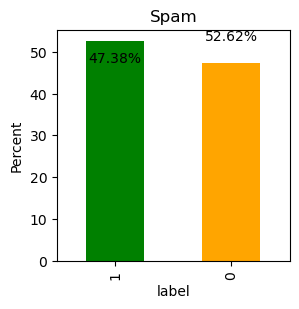

In [4]:
def draw_target_percents(data, target):
    percent_class = (data[target].value_counts() / data.shape[0] * 100)
    colors = ['green', 'orange']
    percent_class.plot(kind='bar', label='Churn', ylabel='Percent', color=colors, figsize=(3,3))
    plt.title('Spam')
    for index in percent_class.keys():
        plt.text(index, percent_class[index], '{:.2f}%'.format(percent_class[index]),ha='center')
draw_target_percents(data, 'label')

# Text preprocessing

In [13]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    """
    Полная предобработка текста: очистка, лемматизация, удаление стоп-слов
    """
    # Очистка текста
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Удаляем все кроме букв и пробелов
    text = text.lower().strip()  # Приводим к нижнему регистру
    
    # Лемматизация
    doc = nlp(text)
    
    # Извлекаем леммы, исключая стоп-слова, пунктуацию и пробелы
    lemmas = [
        token.lemma_ 
        for token in doc 
        if not token.is_stop 
           and not token.is_punct 
           and not token.is_space
           and len(token.lemma_) > 2  # Исключаем короткие слова
    ]
    
    return lemmas

In [16]:
data['text_clean'] = data['text'].apply(preprocess_text)

In [17]:
data.to_csv('Data/cleanData.csv')

In [28]:
X, Y = data['text_clean'], data['label']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

# self-written Naive Bayes 

In [ ]:
from collections import defaultdict


class NaiveBayes:
    def __init__(self, delta=1, minP=0.00000001):
        self.delta= delta
        self.vocab = set()
        self.P_class = defaultdict(int)
        self.cnt_x_spam = defaultdict(int)
        self.cnt_x_not_spam = defaultdict(int)
        self.P_x_y_spam = defaultdict(int)
        self.P_x_y_NOTspam = defaultdict(int)
        self.minP = minP
        
    def fit(self, X, Y):
        self.P_class['spam'] = Y.sum() / Y.shape[0]
        self.P_class['ham'] = 1 - self.P_class['spam']
        
        for text, label in zip(X,Y):
            for word in text:
                self.vocab.add(word)
                if label == 1:
                    self.cnt_x_spam[word] += 1
                else:
                    self.cnt_x_not_spam[word] += 1
            
        
        amt_words_in_spam = sum(self.cnt_x_spam.values())
        amt_words_in_not_spam = sum(self.cnt_x_not_spam.values())
        
        for word, freq in self.cnt_x_spam.items():
            P_x_y = (self.delta + freq) / (self.delta * len(self.vocab)  + amt_words_in_spam)
            if P_x_y > self.minP:
                self.P_x_y_spam[word] = P_x_y
            
        for word, freq in self.cnt_x_not_spam.items():
            P_x_y =  (self.delta + freq) / (self.delta * len(self.vocab) + amt_words_in_not_spam)
            if P_x_y > self.minP:
                self.P_x_y_NOTspam[word] = P_x_y 
                
    def predict(self, X):
        ans = []
        for text in X:
            logS_spam = np.log(self.P_class['spam'])
            logS_notSpam = np.log(self.P_class['ham'])
            for word in text:
                if word in self.P_x_y_spam:
                    logS_spam += np.log(self.P_x_y_spam[word])
                if word in self.P_x_y_NOTspam:
                    logS_notSpam += np.log(self.P_x_y_NOTspam[word])
            if logS_spam > logS_notSpam:
                ans.append(1)
            else:
                ans.append(0)
        return ans


In [134]:
NB_clf = NaiveBayes()
NB_clf.fit(X_train, Y_train)

In [135]:
y_pred = NB_clf.predict(X_test)

In [136]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    results = {}
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    results['Precision'] = precision
    results['Recall'] = recall
    results['F1'] = f1
    results['Accuracy'] = accuracy

    print("result of " + model_name)
    for metric, value in results.items():
        print(metric, value)
    return results


In [138]:
SelfNB_results = evaluate_model(Y_test, y_pred, 'NaiveBayes')

result of NaiveBayes
Precision 0.5085492227979275
Recall 0.44705078569801865
F1 0.47582111259241305
Accuracy 0.481725584182145
